# Prediction of Volatiltiy with Deep Learning and GARCH model

This notebook aims to predict market volatility using machine learning integrated with an econometrics model.

Data from ```'HKEX', 'NYSE', 'NASDAQ', 'AMEX'``` during ```1998-01-01 to 2021-09-07``` was employed.

## Volatiltiy

The volatility $\sigma$, of a stock is a measure of our uncertainty about the returns provided by the stock. It can be defined as the standard deviation of the return provided by the stock. Volatility can be measured in several ways:
1. Historical volatility is calculated from historical data of a stock price.
2. Implied volatility is calculated from prices observed in the market.

# Setup

## Import Libraries

In [12]:
import os
import sys
import mysql.connector

import pandas as pd
import numpy as np
import math
import timeit
import warnings

# Environment variables
from dotenv import load_dotenv
load_dotenv("mysql.env")

# Visualization + diagnositic
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import probplot, shapiro

warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Model
from arch import arch_model
from arch.__future__ import reindexing


# Performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Darwin x86_64

3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:59:00) 
[Clang 11.1.0 ]


# List of Stocks and ETFs
Provided by Thomas Choi.

In [13]:
stock_list = pd.read_csv("stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("stocks_and_etfs/etf_list.csv")

In [40]:
stock_symbol = stock_list.iloc[4,0]
stock_symbol

'AAPL'

## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [41]:
HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Load Data

In [42]:
df = histdailyprice3.copy()
df.set_index("Date", drop=True, inplace=True)
df.head()

,Close,Open,High,Low,Volume
Date,,,,,
1998-01-01,0.1172,0.1172,0.1172,0.1172,0
1998-01-02,0.1217,0.1451,0.1205,0.1451,25646800
1998-01-05,0.1473,0.1479,0.1356,0.1418,23277200
1998-01-06,0.1423,0.1786,0.1317,0.1691,64766000
1998-01-07,0.1680,0.1697,0.1546,0.1563,37200800


## Closing Price

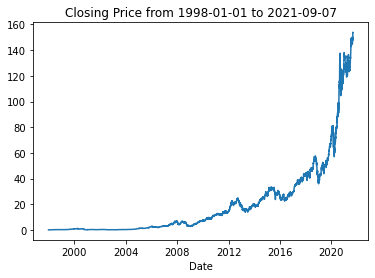

In [43]:
df['Close'].plot(title=f'Closing Price from 1998-01-01 to 2021-09-07')
plt.show()

## Calculate Daily Returns
The formula for return is the following, where $u$ denotes return and $S$ denotes the price of an underlying asset:
$$ u_n = \frac{S_n - S_{n-1}}{S_{n-1}} $$

In [44]:
df['pct_change'] = 100 * df['Close'].pct_change()

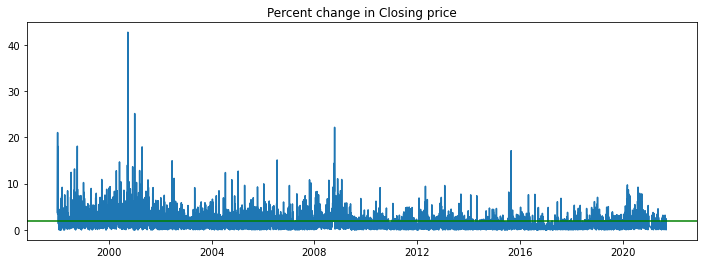

In [45]:
threshold = 2

df.dropna(inplace=True)
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(abs(df['pct_change']), label = 'Percent change')
plt.axhline(y=threshold, color='g', linestyle='-')
plt.title('Percent change in Closing price')
plt.show()

## Calculate daily, monthly, and annual volatitily

In [46]:
daily_volatility = df['pct_change'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  2.66%
Monthly volatility:  12.20%
Annual volatility:  42.27%


## ACF and PACF

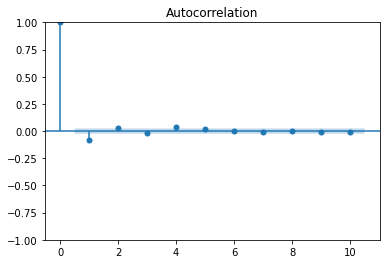

In [47]:
# create acf plot
plot_acf(df["pct_change"], lags=10)
plt.show()

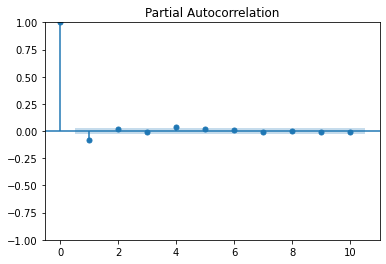

In [48]:
# create pacf plot
plot_pacf(df["pct_change"], lags=10, method='ywm')
plt.show()

## Ljung-Box Test

Ljung-Box is a test for autocorrelation that we can use in tandem with our ACF and PACF plots. The Ljung-Box test takes our data, optionally either lag values to test, or the largest lag value to consider, and whether to compute the Box-Pierce statistic. Ljung-Box and Box-Pierce are two similar test statisitcs, $Q$ , that are compared against a chi-squared distribution to determine if the series is white noise. We might use the Ljung-Box test on the residuals of our model to look for autocorrelation, ideally our residuals would be white noise.

- $H_o$ : The data are independently distributed, no autocorrelation.
- $H_a$ : The data are not independently distributed; they exhibit serial correlation.
The Ljung-Box with the Box-Pierce option will return, for each lag, the Ljung-Box test statistic, Ljung-Box p-values, Box-Pierce test statistic, and Box-Pierce p-values.

If  p<α  (0.05) we reject the null hypothesis.

In [49]:
ljung_res = acorr_ljungbox(df['pct_change'], lags= 40, boxpierce=True)
ljung_res.head()

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,43.294066,4.710097e-11,43.272941,4.761226e-11
2,47.852881,4.063301e-11,47.828789,4.112544e-11
3,49.390832,1.077012e-10,49.365489,1.090477e-10
4,57.619463,9.171719e-12,57.586089,9.320828e-12
5,59.122497,1.845041e-11,59.087412,1.876077e-11


## Time Series Plot Summary

In [50]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags, method="ywm")
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

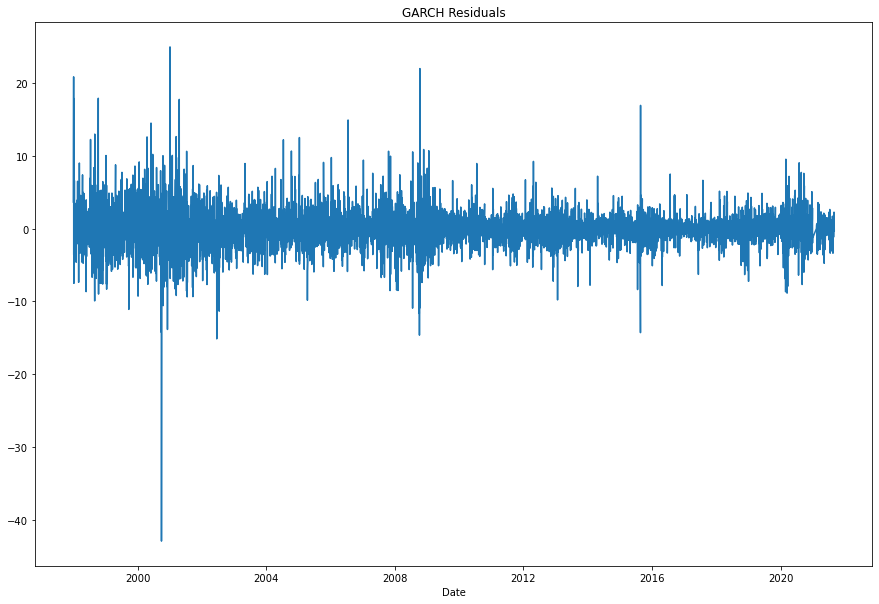

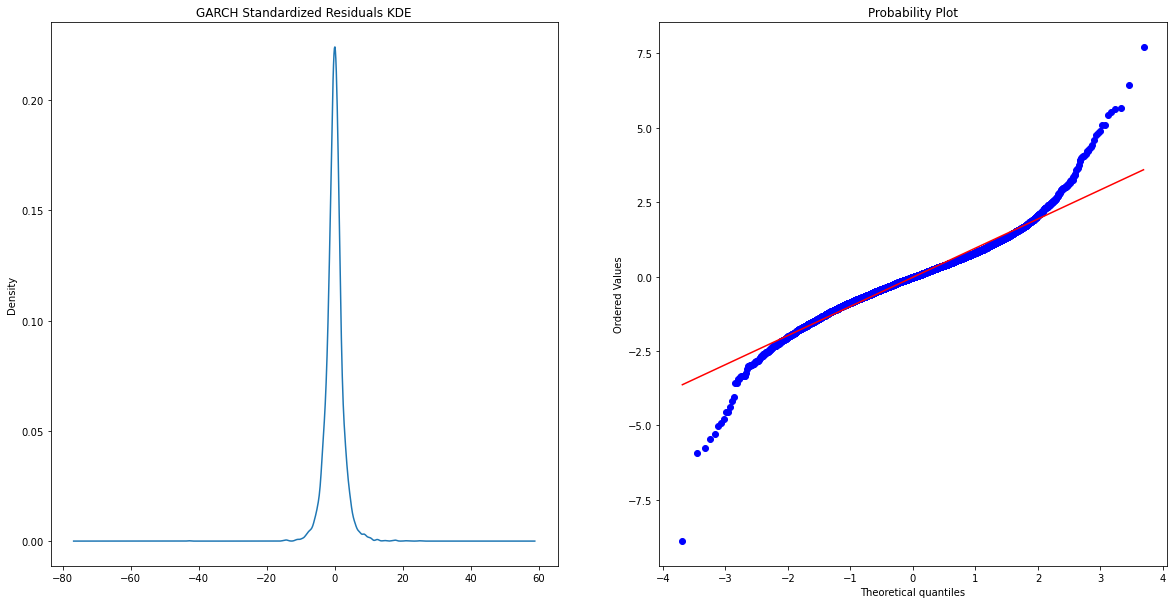

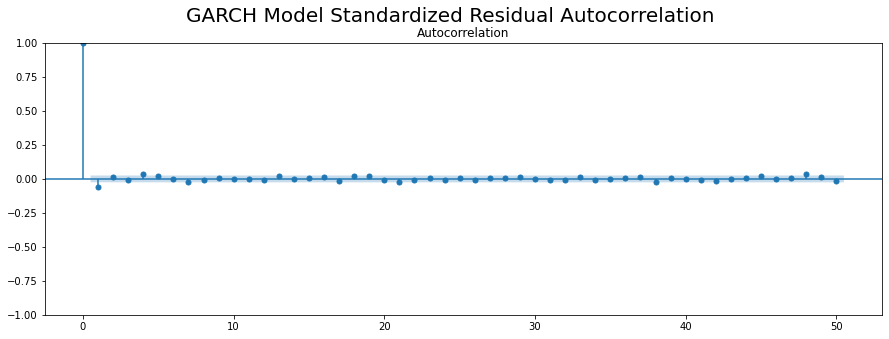

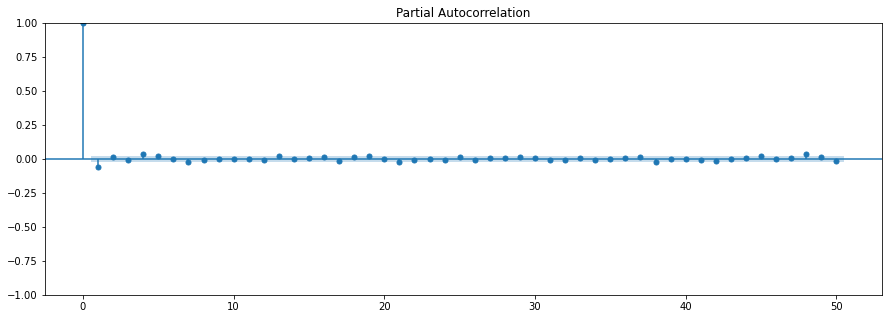

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13781.3
Distribution:                  Normal   AIC:                           27570.5
Method:            Maximum Likelihood   BIC:                           27597.4
                                        No. Observations:                 6146
Date:                Tue, Oct 19 2021   Df Residuals:                     6145
Time:                        15:48:47   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2053  2.800e-02      7.333  2.246e-13 [  0.150,  0.260]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0851  4.717e-02      1.805  7.111e-02 [-7.321e-03,  0.178]
alpha[1]       0.0825  3.244e-02      2.542  1.102e-02  [1.889e-02,  0.146]
beta[1]        0.9078  3.525e-02     25.754 2.875e-146    [  0.839,  0.977]
===========================================================================

Covariance estimator: robust
"""

In [51]:
garch = arch_model(df['pct_change'], vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()

In [52]:
arch_test = het_arch(resid, nlags=50)
shapiro_test = shapiro(st_resid)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 7.514448806150003e-39
F test p-value: 4.488911499524183e-40
Shapiro-Wilks p-value: 8.687440913981885e-39


# GARCH model
Generalized Auto Regressive Conditional Heteroskedasticity <br>
GARCH(1,1) is a widely used econmetric model to estimate historical volatility.

GARCH estimates the historical volatility in Day $n$ with:
- **Rate of return** in Day n-1, denoted by $u$
- **Volatiltiy** in Day n-1, denoted by $\sigma$ ($\sigma^2$ is variance)

The three coefficients in the model:
- **alpha**, coefficient of $u^2$
- **beta**, coefficient of $\sigma^2$
- **omega**, constant <br>

The formula for estiamting historical volatility is:
$$\sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1}$$


## Model Evaluation

To measure how well our ARCH/GARCH model fit our data:
1. Autocorrelation in the standardized residuals using Ljung-Box test.
2. ARCH effects (conditional heteroskedasticity) in the residuals using Engle's ARCH test on the residuals.
3. Normal distribution in the standardized residuals, we can use the Shapiro-Wilk test, Q-Q plot, and if larger n- the Jarque-Bera test to see if our data approaches normality.

### Engle's ARCH test
Deterin whether our ARCH model has captured the conditional heteroskedasticity of our time series.
- $H_o$ : The squared residuals are a sequence of white noise- the residuals are homoscedastic.
- $H_a$ : The squared residuals could not be fitted with a linear regression model and exhibit heteroskedasticity.

### Shapiro-Wilks test
Evaluates a data sample and quantifies how likely the data was drawn from a Gaussian distribution.
- $H_o$ : The data is normally distributed
- $H_a$: The data is not normally distributed

### Jarque-Bera Test
A type of lagrange multiplier test for normality. Usually used for large data sets because other normality tests are not reliable when n is large, Shapiro-Wilk is not reliable with n more than 2,000. Jarque-Bera specifically matches skewness and kurtosis to a normal distribution.
- $H_o$ : The data is normally distributed
- $H_a$: The data is not normally distributed

## Grid Search
Parameter tuning

In [53]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models

## Model Evaluation

In [54]:
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, nlags=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [55]:
p_rng = range(0,30)
q_rng = range(0,40)
df['dif_pct_change'] = df['pct_change']#.diff()

# Time the grid search
start = timeit.default_timer()

top_models = gridsearch(df['dif_pct_change'], p_rng, q_rng)

stop = timeit.default_timer()
print('Time: ', stop - start)

print(top_models)

/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Time:  2107.1547040990004
[{'LM_pvalue': [1.340307635080779e-38, True], 'F_pvalue': [8.253221428062688e-40, True], 'SW_pvalue': [1.7409255006670394e-34, True], 'AIC': 27421.441976149785, 'params': {'p': 8, 'q': 32}}]


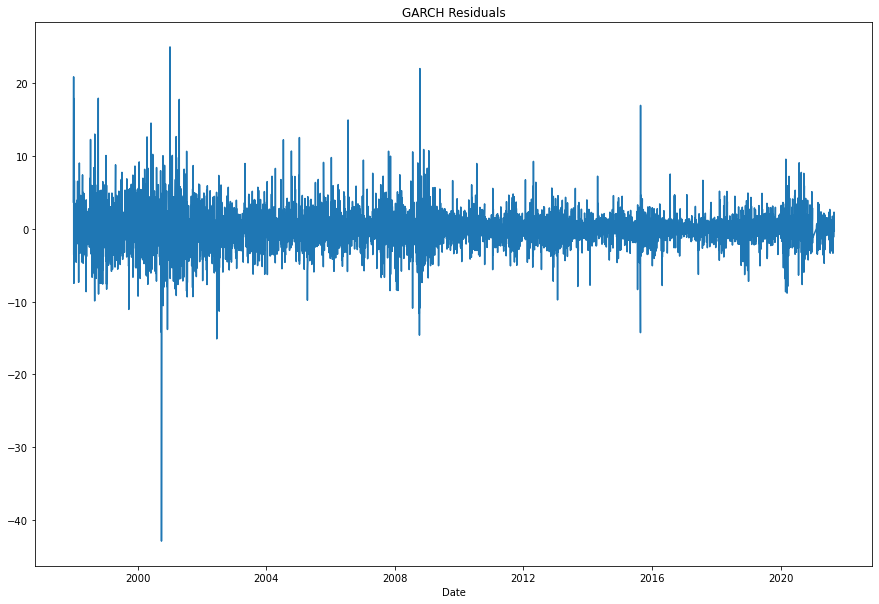

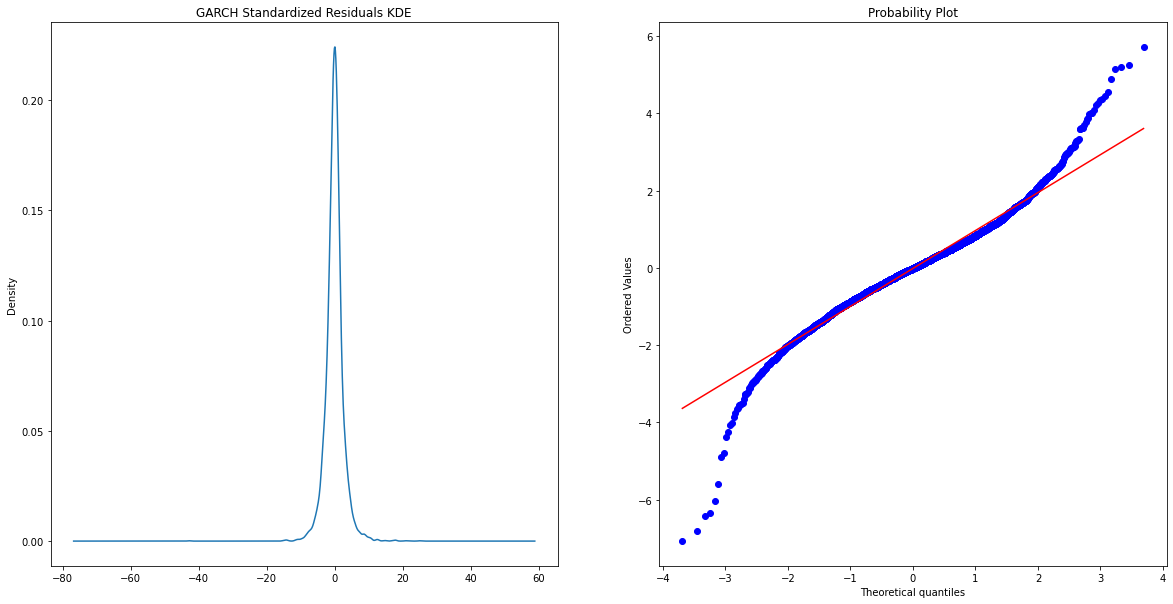

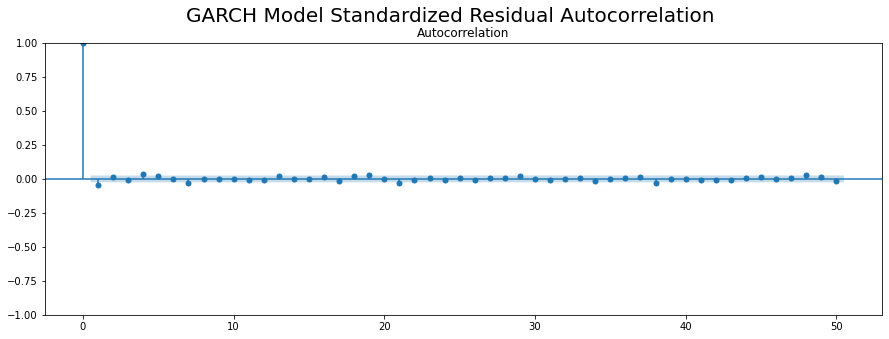

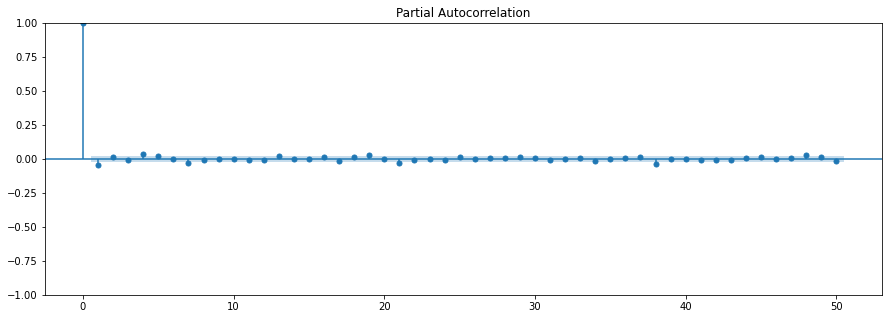

Lagrange mulitplier p-value: 1.340307635080779e-38
F test p-value: 8.253221428062688e-40
Shapiro-Wilks p-value: 1.7409255006670394e-34


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13668.7
Distribution:                  Normal   AIC:                           27421.4
Method:            Maximum Likelihood   BIC:                           27703.8
                                        No. Observations:                 6146
Date:                Tue, Oct 19 2021   Df Residuals:                     6145
Time:                        16:23:57   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1778  7.976e-02      2.229  2.580e-02 [2.148e-02,  0.334]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2877      1.753      0.164      0.870 [ -3.148,  3.723]
alpha[1]       0.1309      0.650      0.202      0.840 [ -1.142,  1.404]
alpha[2]       0.0838      0.308      0.272      0.786 [ -0.520,  0.688]
alpha[3]       0.0448      1.029  4.350e-02      0.965 [ -1.972,  2.062]
alpha[4]       0.0221      1.349  1.640e-02      0.987 [ -2.621,  2.666]
alpha[5]       0.1255      1.512  8.297e-02      0.934 [ -2.839,  3.090]
alpha[6]   1.6862e-09      0.591  2.853e-09      1.000 [ -1.159,  1.159]
alpha[7]   6.5560e-03      0.112  5.861e-02      0.953 [ -0.213,  0.226]
alpha[8]       0.0308      1.106  2.788e-02      0.978 [ -2.137,  2.199]
beta[1]    1.2050e-09      1.733  6.955e-10      1.000 [ -3.396,  3.396]
beta[2]    7.9391e-10      4.978  1.595e-10      1.000 [ -9.756,  9.756]
beta[3]    1.1403e-09      3.370  3.383e-10      1.000 [ -6.606,  6.606]
beta[4]    2.1007e-10      2.661  7.895e-11      1.000 [ -5.215,  5.215]
beta[5]    1.4951e-09      1.073  1.394e-09      1.000 [ -2.102,  2.102]
beta[6]    1.4340e-10      4.395  3.263e-11      1.000 [ -8.614,  8.614]
beta[7]    4.1636e-10      4.499  9.255e-11      1.000 [ -8.817,  8.817]
beta[8]        0.0363      0.656  5.535e-02      0.956 [ -1.249,  1.322]
beta[9]    9.2724e-10      2.712  3.419e-10      1.000 [ -5.316,  5.316]
beta[10]       0.0000      2.394      0.000      1.000 [ -4.693,  4.693]
beta[11]       0.0351      1.349  2.605e-02      0.979 [ -2.609,  2.679]
beta[12]   8.6370e-10      1.310  6.593e-10      1.000 [ -2.568,  2.568]
beta[13]   1.7424e-09      1.787  9.750e-10      1.000 [ -3.502,  3.502]
beta[14]   1.6196e-09      0.306  5.293e-09      1.000 [ -0.600,  0.600]
beta[15]       0.0147      0.919  1.600e-02      0.987 [ -1.787,  1.817]
beta[16]   1.4080e-09      0.404  3.487e-09      1.000 [ -0.791,  0.791]
beta[17]   2.5834e-09      1.615  1.600e-09      1.000 [ -3.165,  3.165]
beta[18]   1.0283e-09      0.226  4.558e-09      1.000 [ -0.442,  0.442]
beta[19]   4.7653e-10      0.224  2.128e-09      1.000 [ -0.439,  0.439]
beta[20]   1.7374e-09      0.722  2.408e-09      1.000 [ -1.414,  1.414]
beta[21]   2.6821e-09      3.155  8.500e-10      1.000 [ -6.184,  6.184]
beta[22]       0.0229      0.157      0.145      0.885 [ -0.286,  0.331]
beta[23]   6.9776e-10      1.184  5.895e-10      1.000 [ -2.320,  2.320]
beta[24]   1.5861e-09      1.969  8.056e-10      1.000 [ -3.859,  3.859]
beta[25]   1.1220e-09      2.003  5.602e-10      1.000 [ -3.925,  3.925]
beta[26]   3.

In [56]:
p = top_models[0]['params']['p']
q = top_models[0]['params']['q']
garch = arch_model(df['pct_change'], vol='GARCH', p=p, q=q, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
arch_test = het_arch(resid, nlags=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')
fgarch.summary()

# Predict Stock Volatilty

In [57]:
garch_model = arch_model(df['pct_change'], p = p, q = q,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          1.778067e-01
omega       2.876992e-01
alpha[1]    1.309349e-01
alpha[2]    8.382346e-02
alpha[3]    4.477140e-02
alpha[4]    2.212206e-02
alpha[5]    1.254789e-01
alpha[6]    1.686205e-09
alpha[7]    6.555960e-03
alpha[8]    3.083210e-02
beta[1]     1.204985e-09
beta[2]     7.939125e-10
beta[3]     1.140313e-09
beta[4]     2.100748e-10
beta[5]     1.495096e-09
beta[6]     1.433982e-10
beta[7]     4.163573e-10
beta[8]     3.630281e-02
beta[9]     9.272422e-10
beta[10]    0.000000e+00
beta[11]    3.514404e-02
beta[12]    8.636993e-10
beta[13]    1.742351e-09
beta[14]    1.619569e-09
beta[15]    1.470750e-02
beta[16]    1.407956e-09
beta[17]    2.583369e-09
beta[18]    1.028290e-09
beta[19]    4.765259e-10
beta[20]    1.737379e-09
beta[21]    2.682074e-09
beta[22]    2.285516e-02
beta[23]    6.977640e-10
beta[24]    1.586056e-09
beta[25]    1.121968e-09
beta[26]    3.007548e-10
beta[27]    8.334326e-10
beta[28]    6.922000e-02
beta[29]    6.227110e-10
beta[30]    1.568269e-10


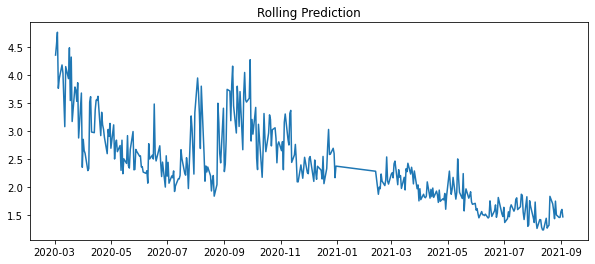

In [58]:
rolling_predictions = []
test_size = 365
for i in range(test_size):
    train = df['pct_change'][:-(test_size-i)]
    model = arch_model(train, p=p, q=q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df['pct_change'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

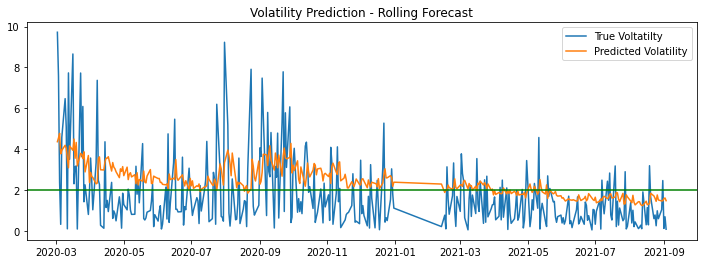

In [59]:
plt.figure(figsize=(12,4))
plt.plot(abs(df['pct_change'][-365:]))
plt.plot(rolling_predictions)
plt.axhline(y=threshold, color='g', linestyle='-')
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Voltatilty', 'Predicted Volatility'])
plt.show()

# INTEGRATE With DEEP LEARNING
AFTER UP or DOWN model
Model Stacking <br>
Ensemble stacking

TODO: Running on the 200-300 stocks <br>

Relationship between volatiltiy between up and down <br>
Up = low voltatilty, down = high volatility <br>

Consider performance on different stocks, may have to choose which stock this model is good at.

TODO: LSTM /BILSTM

# Performance Metric

In [60]:
y_pred = np.array(rolling_predictions >= 2)
y_true = np.array(abs(df['pct_change'][-365:]) >= 2)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("tn:", tn, "fp:", fp, "fn:", fn, "tp:", tp)

# Precision score
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
print("Macro precision score:", precision_macro)
print("Micro precision score:", precision_micro)

# f1 score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
print("Macro f1 score:", f1_macro)
print("Micro f1 score:", f1_micro)

tn: 95 fp: 157 fn: 20 tp: 93
Macro precision score: 0.5990434782608696
Micro precision score: 0.5150684931506849
Macro f1 score: 0.5150539329385007
Micro f1 score: 0.5150684931506849


# Performance on multiple stocks

## TXT

In [61]:
filename = f'reports/GARCH performance on stocks and etfs'
with open(filename, 'a') as f:
    f.write(f"\n{stock_symbol}:\nMacro precision score: {precision_macro}\nMicro precision score: {precision_micro}\nMacro f1 score: {f1_macro}\nMicro f1 score: {f1_micro}\n")

## CSV

In [62]:
garch_performance = pd.read_csv("reports/GARCH_performance.csv")
garch_performance = garch_performance.drop(["Unnamed: 0"], axis=1)
garch_performance

,Stock,Macro precision,Micro precision,Macro f1,Micro f1
0,MSFT,0.603042,0.676712,0.605586,0.676712
1,INTC,0.536922,0.427397,0.427380,0.427397
2,EBAY,0.532039,0.419178,0.411756,0.419178
3,XOM,0.555394,0.515068,0.511770,0.515068


In [63]:
garch_performance.loc[len(garch_performance.index)] = [stock_symbol, precision_macro, precision_micro, f1_macro, f1_micro]
garch_performance

,Stock,Macro precision,Micro precision,Macro f1,Micro f1
0,MSFT,0.603042,0.676712,0.605586,0.676712
1,INTC,0.536922,0.427397,0.427380,0.427397
2,EBAY,0.532039,0.419178,0.411756,0.419178
3,XOM,0.555394,0.515068,0.511770,0.515068
4,AAPL,0.599043,0.515068,0.515054,0.515068


In [64]:
garch_performance.to_csv("reports/GARCH_performance.csv")

# Work Cited
Liu, Wing Ki, and Mike K. P. So. "A GARCH Model with Artifical Neural Networks." 20 Oct 2020.